In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import math
import random

from torch.autograd import Variable

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
in_dim, hid1_dim, hid2_dim, out_dim = 4, 8, 9, 3

In [4]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [5]:
EPOCHS = 500
loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))
act_func_relu = torch.nn.ReLU()
act_func_cel = torch.nn.CrossEntropyLoss()
loss_func = torch.nn.CrossEntropyLoss()

In [6]:
def get_fitness(X_train, y_train, weights, act_func_relu, act_func_cel, loss_func):
    w1, w2, w3 = [], [], []
    lengths = 0
    for i in range(in_dim) :
        w1.append(weights[lengths : hid1_dim + lengths])
        lengths += hid1_dim
    w1 = np.array(w1)
    
    for i in range(hid1_dim) :
        w2.append(weights[lengths : hid2_dim + lengths])
        lengths += hid2_dim
    w2 = np.array(w2)
    
    for i in range(hid2_dim) :
        w3.append(weights[lengths : out_dim + lengths])
        lengths += out_dim
    w3 = np.array(w3)

    w1, w2, w3 = Variable(torch.from_numpy(w1)).float(), Variable(torch.from_numpy(w2)).float(), Variable(torch.from_numpy(w3)).float()
    
    y_pred = X_train.mm(w1)
    y_pred = act_func_relu(y_pred)
    y_pred = y_pred.mm(w2)
    y_pred = act_func_relu(y_pred)
    y_pred = y_pred.mm(w3)
    loss = loss_func(y_pred, y_train)
    
    return loss.item()

def tester(X_test, y_test, weights, act_func_relu, act_func_cel):
    w1, w2, w3 = [], [], []
    lengths = 0
    for i in range(in_dim) :
        w1.append(weights[lengths : hid1_dim + lengths])
        lengths += hid1_dim
    w1 = np.array(w1)
    
    for i in range(hid1_dim) :
        w2.append(weights[lengths : hid2_dim + lengths])
        lengths += hid2_dim
    w2 = np.array(w2)
    
    for i in range(hid2_dim) :
        w3.append(weights[lengths : out_dim + lengths])
        lengths += out_dim
    w3 = np.array(w3)

    w1, w2, w3 = Variable(torch.from_numpy(w1)).float(), Variable(torch.from_numpy(w2)).float(), Variable(torch.from_numpy(w3)).float()
    
    t_y_pred = X_test.mm(w1)
    t_y_pred = act_func_relu(t_y_pred)
    t_y_pred = t_y_pred.mm(w2)
    t_y_pred = act_func_relu(t_y_pred)
    t_y_pred = t_y_pred.mm(w3)
    
    return t_y_pred

In [7]:
swarm_no = 20
lb, ub, dim = -10, 10, in_dim * hid1_dim + hid1_dim * hid2_dim + hid2_dim * out_dim

In [24]:
population = np.zeros((swarm_no, dim))
particle_best_pos = np.zeros((swarm_no, dim))
particle_best_sco = np.zeros((swarm_no))
swarm_best_pos = np.zeros(dim)
swarm_best_sco = float("inf")

inertia_w = 1 # inertia constant
c1 = 2 # cognitive constant
c2 = 2 # social constant

for i in range(swarm_no) :
    population[i, :] = (np.random.uniform(lb, ub, dim))
    init_fit = get_fitness(X_train, y_train, population[i, :], act_func_relu, act_func_cel, loss_func)
    
    particle_best_pos[i, :] = population[i, :]
    particle_best_sco[i] = fit 
    
    if swarm_best_sco > fit :
        swarm_best_pos = population[i, :]
        swarm_best_sco = fit

In [32]:
for iter in range(EPOCHS) :
    for i in range(swarm_no) :
        current_pos = population[i, :]
        velocity = current_pos * inertia_w
        social_best = swarm_best_pos - current_pos
        particle_best = particle_best_pos[i] - current_pos
        r1, r2 = round(random.random(), 6), round(random.random(), 6)
        
        # update particle
        result_pos = inertia_w * velocity + c1 * r1 * particle_best + c2 * r2 * social_best
        result_fit = get_fitness(X_train, y_train, result_pos, act_func_relu, act_func_cel, loss_func)
        
        population[i, :] = result_pos
        
        # update particle_best
        if particle_best_sco[i] > result_fit :
            particle_best_pos[i] = result_pos
            particle_best_sco[i] = result_fit
            
        # update swarm_best
        if swarm_best_sco > result_fit :
            swarm_best_pos = result_pos
            swarm_best_sco = result_fit
    
    loss_list[iter] = swarm_best_sco
    if iter % 20 == 0:
         print(iter, "loss :", swarm_best_sco, end="")
            
    w_set = swarm_best_pos
    valid = tester(X_test, y_test, w_set, act_func_relu, act_func_cel)
    correct = (torch.argmax(valid, dim=1) == y_test).type(torch.FloatTensor)
    accuracy_list[iter] = correct.mean().item()
    if iter % 20 == 0:
         print(' ', "acc :", correct.mean().item())

0 loss : 32.816429138183594  acc : 0.7333333492279053
20 loss : 3.3750569820404053  acc : 0.8333333134651184
40 loss : 3.272258758544922  acc : 0.8333333134651184
60 loss : 3.1513969898223877  acc : 0.8333333134651184
80 loss : 2.8040244579315186  acc : 0.8333333134651184
100 loss : 2.7954587936401367  acc : 0.8333333134651184
120 loss : 2.7954397201538086  acc : 0.8333333134651184
140 loss : 2.7948975563049316  acc : 0.8333333134651184
160 loss : 2.794895648956299  acc : 0.8333333134651184
180 loss : 2.7948949337005615  acc : 0.8333333134651184
200 loss : 2.7948944568634033  acc : 0.8333333134651184
220 loss : 2.7948944568634033  acc : 0.8333333134651184
240 loss : 2.7948944568634033  acc : 0.8333333134651184
260 loss : 2.794894218444824  acc : 0.8333333134651184
280 loss : 2.794894218444824  acc : 0.8333333134651184
300 loss : 2.794894218444824  acc : 0.8333333134651184
320 loss : 2.794894218444824  acc : 0.8333333134651184
340 loss : 2.794894218444824  acc : 0.8333333134651184
360 l

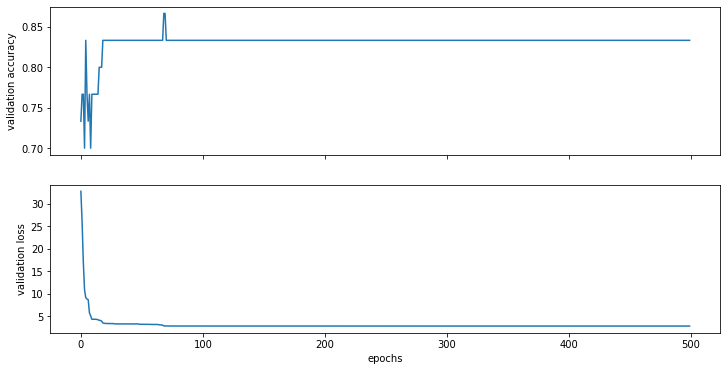

In [33]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");